# GPU check + imports


In [2]:
import tensorflow as tf

# Ver dispositivos disponibles
print("Dispositivos disponibles:")
for device in tf.config.list_physical_devices():
    print(device)

# Ver si TensorFlow está usando GPU
if tf.test.is_gpu_available():
    print("\n✅ TensorFlow está usando la GPU.")
    print("GPU en uso:", tf.config.experimental.list_physical_devices('GPU'))
else:
    print("\n❌ TensorFlow NO está usando la GPU.")


Dispositivos disponibles:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.

✅ TensorFlow está usando la GPU.
GPU en uso: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, False)  # Usar toda la memoria

In [14]:
import numpy as np
import itertools
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Activation, Dense
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import os
import random
import shutil
import pandas as pd





# ACTUAL MODEL

## CREACION DE DATAFRAME

In [5]:
# INDICAR RUTA CON LAS IMAGENES!!!
data_dir = "../data/morton14k"

CLASS_RULES = {
    "chat": ["chat"],
    "email": ["email"],
    "voice": ["audio", "voipbuster"],
    "streaming": ["vimeo", "netflix", "spotify", "youtube", "video"],
    "filetransfer": ["sftp", "ftps", "files", "file"],
    "p2p": ["bittorrent"]
}

# Función para asignar una etiqueta según el nombre del archivo
def get_label(filename):
    for category, keywords in CLASS_RULES.items():
        if any(keyword in filename.lower() for keyword in keywords):
            return category
    return None

image_paths = []
labels = []

for root, _, files in os.walk(data_dir):  # Recorre todas las carpetas y archivos
    for file in files:
        if file.endswith(".png"):
            label = get_label(file)
            if label:
                image_paths.append(os.path.join(root, file))
                labels.append(label)

# Crear DataFrame
df = pd.DataFrame({"image_path": image_paths, "label": labels})

print(df.tail())
print(df["label"].value_counts().to_frame().reset_index().rename(columns={"index": "Etiqueta", "label": "Cantidad"}))


                                              image_path      label
86995  ../data/morton14k\f_youtubeHTML5_1_9880.bin_mo...  streaming
86996  ../data/morton14k\f_youtubeHTML5_1_9888.bin_mo...  streaming
86997  ../data/morton14k\f_youtubeHTML5_1_990.bin_mor...  streaming
86998  ../data/morton14k\f_youtubeHTML5_1_9959.bin_mo...  streaming
86999  ../data/morton14k\f_youtubeHTML5_1_9987.bin_mo...  streaming
       Cantidad  count
0          chat  14500
1         email  14500
2         voice  14500
3     streaming  14500
4  filetransfer  14500
5           p2p  14500


In [6]:
# Crear un diccionario para convertir etiquetas en números
label_map = {label: idx for idx, label in enumerate(df["label"].unique())}
df["label"] = df["label"].map(label_map)  # Convertimos a números

# Función para cargar imágenes y etiquetas
# Función para cargar imágenes y convertir etiquetas a one-hot encoding
def load_image_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)  # Convertir PNG a tensor
    img = tf.image.resize(img, (32, 32))  # Asegurar tamaño correcto
    img = img / 255.0  # Normalización [0,1]

    label = tf.one_hot(label, depth=6)  # Convertir etiqueta a one-hot
    return img, label


# Convertir el DataFrame en un Dataset de TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["label"].values))
dataset = dataset.map(load_image_label)

# Mostrar un ejemplo
for img, label in dataset.take(1):  
    print(img.shape, label.numpy())

(32, 32, 3) [1. 0. 0. 0. 0. 0.]


In [7]:
## SEPARACION DE TRAINING Y VALIDATION DATA

# Ver distribución de clases antes de dividir
print("Distribución de clases en el dataset original:\n")
print(df["label"].value_counts())

# Dividir en entrenamiento y validación asegurando la estratificación
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

# Verificar distribución después de dividir
print("\nDistribución de clases en el dataset de entrenamiento:")
print(train_df["label"].value_counts())

print("\nDistribución de clases en el dataset de validación:")
print(val_df["label"].value_counts())

# Crear datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((train_df["image_path"].values, train_df["label"].values))
val_dataset = tf.data.Dataset.from_tensor_slices((val_df["image_path"].values, val_df["label"].values))

# Aplicar la función de carga de imágenes
train_dataset = train_dataset.map(load_image_label)
val_dataset = val_dataset.map(load_image_label)

# Contar elementos en los datasets de TensorFlow
train_count = sum(1 for _ in train_dataset)
val_count = sum(1 for _ in val_dataset)

print(f"\nTotal imágenes en entrenamiento: {train_count}")
print(f"Total imágenes en validación: {val_count}")

# Mezclar, agrupar en batches y optimizar
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)


Distribución de clases en el dataset original:

label
0    14500
1    14500
2    14500
3    14500
4    14500
5    14500
Name: count, dtype: int64

Distribución de clases en el dataset de entrenamiento:
label
1    11600
2    11600
5    11600
0    11600
4    11600
3    11600
Name: count, dtype: int64

Distribución de clases en el dataset de validación:
label
1    2900
2    2900
5    2900
4    2900
3    2900
0    2900
Name: count, dtype: int64

Total imágenes en entrenamiento: 69600
Total imágenes en validación: 17400


## MODELO

Epoch 1/10
1088/1088 [==============================] - 33s 29ms/step - loss: 1.4689 - accuracy: 0.3881 - val_loss: 1.4105 - val_accuracy: 0.4155
Epoch 2/10
1088/1088 [==============================] - 30s 27ms/step - loss: 1.3855 - accuracy: 0.4246 - val_loss: 1.3740 - val_accuracy: 0.4376
Epoch 3/10
1088/1088 [==============================] - 30s 27ms/step - loss: 1.3543 - accuracy: 0.4449 - val_loss: 1.3553 - val_accuracy: 0.4310
Epoch 4/10
1088/1088 [==============================] - 31s 28ms/step - loss: 1.3335 - accuracy: 0.4593 - val_loss: 1.3314 - val_accuracy: 0.4554
Epoch 5/10
1088/1088 [==============================] - 30s 28ms/step - loss: 1.3171 - accuracy: 0.4678 - val_loss: 1.3168 - val_accuracy: 0.4613
Epoch 6/10
1088/1088 [==============================] - 30s 27ms/step - loss: 1.3051 - accuracy: 0.4721 - val_loss: 1.3038 - val_accuracy: 0.4728
Epoch 7/10
1088/1088 [==============================] - 31s 28ms/step - loss: 1.2951 - accuracy: 0.4775 - val_loss: 1.2952 -

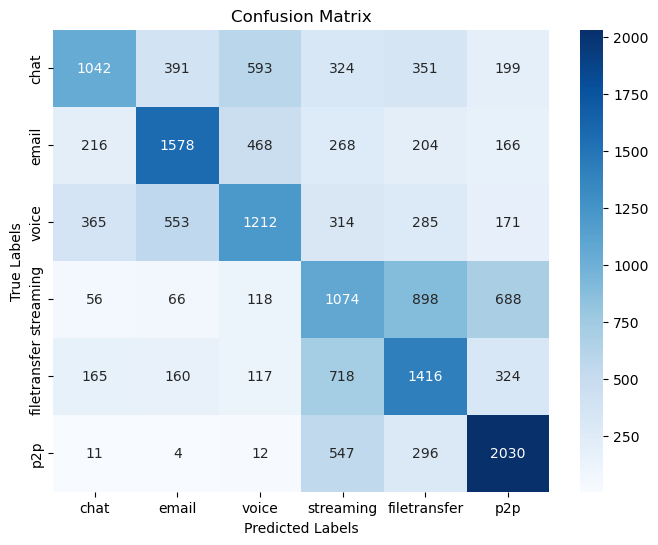

              precision    recall  f1-score   support

        chat       0.56      0.36      0.44      2900
       email       0.57      0.54      0.56      2900
       voice       0.48      0.42      0.45      2900
   streaming       0.33      0.37      0.35      2900
filetransfer       0.41      0.49      0.45      2900
         p2p       0.57      0.70      0.63      2900

    accuracy                           0.48     17400
   macro avg       0.49      0.48      0.48     17400
weighted avg       0.49      0.48      0.48     17400

Epoch 1/5
1088/1088 [==============================] - 65s 57ms/step - loss: 1.2132 - accuracy: 0.5166 - val_loss: 1.1615 - val_accuracy: 0.5503
Epoch 2/5
1088/1088 [==============================] - 62s 56ms/step - loss: 1.1231 - accuracy: 0.5634 - val_loss: 1.0984 - val_accuracy: 0.5783
Epoch 3/5
1088/1088 [==============================] - 62s 56ms/step - loss: 1.0834 - accuracy: 0.5835 - val_loss: 1.0761 - val_accuracy: 0.5867
Epoch 4/5
1088/1088 [=

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# Parámetros
IMG_SIZE = (32, 32)
BATCH_SIZE = 128
EPOCHS = 10

label_map = {
    0: 'chat',
    1: 'email',
    2: 'voice',
    3: 'streaming',
    4: 'filetransfer',
    5: 'p2p'
}

# Cargar modelo base VGG19 (sin la capa superior)
base_model = VGG19(weights="imagenet",
                   include_top=False,
                   input_shape=(IMG_SIZE[0],
                                IMG_SIZE[1], 3))

# Congelar las capas base
for layer in base_model.layers:
    layer.trainable = False

# Añadir capas de clasificación personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(128, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(6, activation="softmax")(x)  # 6 clases en tu problema

# Crear modelo final
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Entrenar modelo
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# ===============================
# Evaluación en validación
# ===============================
# Obtener etiquetas verdaderas
val_labels = []
for _, labels in val_dataset:
    val_labels.extend(tf.argmax(labels, axis=1).numpy())

# Predicciones
predictions = model.predict(val_dataset)
pred_labels = np.argmax(predictions, axis=1)

# Matriz de confusión
conf_matrix = confusion_matrix(val_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Reporte de clasificación
print(classification_report(val_labels, pred_labels, target_names=label_map.values()))

# ===============================
# Fine-tuning: Descongelar últimas capas
# ===============================
for layer in base_model.layers[-8:]:  # Últimas 8 capas convolucionales
    layer.trainable = True

# Recompilar con menor tasa de aprendizaje
model.compile(optimizer=Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

# Segundo entrenamiento (fine-tuning)
history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

# Evaluación final
test_loss, test_acc = model.evaluate(val_dataset)
print(f"Test Accuracy after fine-tuning: {test_acc * 100:.2f}%")

# Evaluación final con fine-tuning
val_labels_finetune = []
for _, labels in val_dataset:
    val_labels_finetune.extend(tf.argmax(labels, axis=1).numpy())

predictions_finetune = model.predict(val_dataset)
pred_labels_finetune = np.argmax(predictions_finetune, axis=1)

conf_matrix_finetune = confusion_matrix(val_labels_finetune, pred_labels_finetune)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_finetune, annot=True, fmt='d', cmap="Greens", xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix After Fine-Tuning")
plt.show()


272/272 [==============================] - 6s 21ms/step


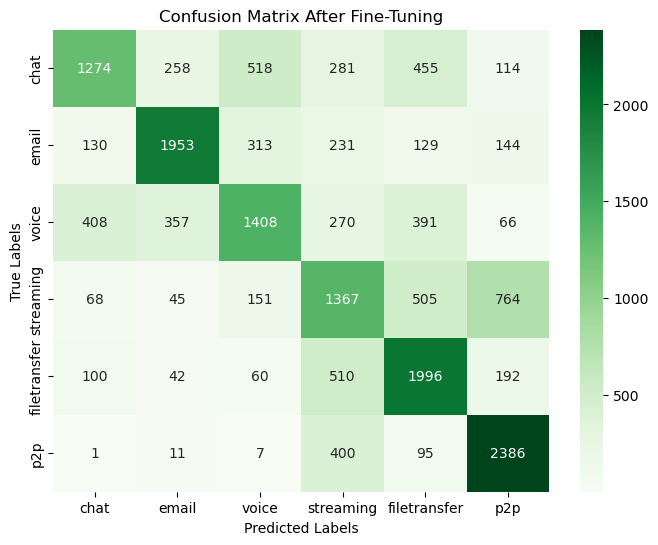